In [1]:
import pandas as pd
import numpy as np

#Import CSV & Clean input
cluster_raw = pd.read_csv('cluster_model.csv', sep=',')


print(cluster_raw)

      index                                               text  cluster
0         0                             hi, how are you doing?       36
1         1                      i'm fine. how about yourself?       23
2         2                i'm pretty good. thanks for asking.       30
3         3                  no problem. so how have you been?       14
4         4                   i've been great. what about you?       23
...     ...                                                ...      ...
3719   3719    that's a good question. maybe it's not old age.       34
3720   3720                              are you right-handed?       43
3721   3721                                  yes. all my life.       54
3722   3722  you're wearing out your right hand. stop using...        8
3723   3723        but i do all my writing with my right hand.       16

[3724 rows x 3 columns]


In [2]:
#Import Spacy & Language Module
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
data_cleaned = cluster_raw


data_cleaned = data_cleaned.text.apply(lambda text: " ".join(token.lemma_ for token in nlp(text)))
#                                                  if not token.is_punct))

#is_stop
#These save as strings, not tokens



In [4]:
#Import Gensim & Cython (technical support library) 
import gensim
from gensim.models import Word2Vec

import Cython

c:\users\beutler\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
#Transform into data useable by Word2Vec
data_model = data_cleaned.apply(lambda line: line.split())

data_model =  data_model.to_numpy().tolist()

#Train Model - Currently 1 iteration:
# min_count = minimum # of instances of a word to create a vector (default 5)
# vector_size = degrees of freedom (default 100, typically between 10 and a few hundred)
# -> Hyperparameters

# workers = Core parallelization (enabled by Cython), speeds up training
# sg = Training algorythm (here 1 is skip-gram)

model_base = Word2Vec(data_model, min_count=10, vector_size=325, workers=4, sg=1 )


#Note: Tokens are never equivalent, so they EACH count as a different word
# -> Should probably still be implemented, but neads to use the text attribute, rather than the tokens,
# needs a different transformation to the current one


c:\users\beutler\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


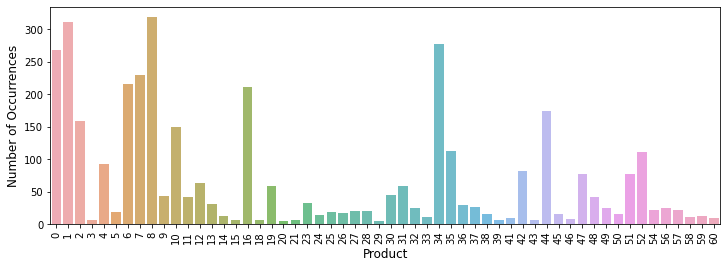

In [6]:
docs_vectors = pd.DataFrame()

for line in cluster_raw['text']: #.str.lower().str.replace('[^a-z ]', ''): 
    
    temp = pd.DataFrame() 
    
    for word in line.split(' '):  #satzzeichen nicht getrennt
    
        try:
            word_vec = model_base.wv[word] 
            temp = temp.append(pd.Series(word_vec), ignore_index = True) 
        except:
            pass
          
    doc_vector = temp.mean() 
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) 
    


docs_vectors['cluster'] = cluster_raw['cluster']
docs_vectors = docs_vectors.dropna()




In [8]:
# Split train / test data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('cluster', axis = 1),
                                                   docs_vectors['cluster'],
                                                   test_size = 0.2,
                                                   random_state = 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)





(2797, 325) (2797,) (700, 325) (700,)


In [28]:
# Ada-Boost
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=800, random_state = 1)
model.fit(train_x, train_y)
test_pred = model.predict(test_x)



print(accuracy_score(test_y, test_pred))

0.13285714285714287


In [29]:
# MLP Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300).fit(train_x, train_y)
clf.predict_proba(test_x[:1])


clf.score(test_x, test_y)

c:\users\beutler\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


0.15142857142857144

In [23]:
#KNN - beste Laufzeit bisher, mit Abstand
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_x, train_y)

neigh.score(test_x, test_y)

0.1742857142857143

In [37]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(train_x, train_y)
test_pred = model.predict(test_x)



print(accuracy_score(test_y, test_pred))


0.13285714285714287


In [ ]:
# Hab mal keine Gaus / Zufallsmodelle genommen, wir wussten ja schon dass die nicht wirklich mit unseren Daten funktionieren